In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import silhouette_score

from feature_extraction import method_flagger # Used for creating our methodology flags

In [29]:
pollsters = pd.read_csv('../data/pollster-ratings.csv')
polls = pd.read_csv('../data/raw-polls-updated.csv')

df = pd.merge(left = polls, right = pollsters, how = 'left', left_on = 'pollster_rating_id', right_on = 'Pollster Rating ID')

df = pd.merge(df, 
              pd.DataFrame(method_flagger(df['methodology'])), 
              left_index=True, 
              right_index=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10776 entries, 0 to 10775
Data columns (total 68 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   poll_id                                       10776 non-null  int64  
 1   question_id                                   10776 non-null  int64  
 2   race_id                                       10776 non-null  int64  
 3   year                                          10776 non-null  int64  
 4   race                                          10776 non-null  object 
 5   location                                      10776 non-null  object 
 6   type_simple                                   10776 non-null  object 
 7   type_detail                                   10776 non-null  object 
 8   pollster                                      10776 non-null  object 
 9   pollster_rating_id                            10776 non-null 

In [32]:
df.isna().sum()[df.isna().sum() > 0] 
# We have some missing values from our merge, we can drop those later once we've selected our features.
# Most NAs are from incomplete information from the pollster ratings data so we have no way to impute or otherwise fix
# those observations. We will drop only the rows with incomplete information for the features we select.
# Partisan has missing values for non-partisan polls (with 1 exception)
# Cand3_pct and comment are only used as necessary
# Bias has a number of missing values which is unexpected but can be easily imputed
# We will use 'calc_bias' which is margin_poll - margin_actual as describe in the data dictionary

partisan                                        9957
cand3_pct                                       6879
bias                                            1952
comment                                         6711
Rank                                              21
Pollster                                          21
Pollster Rating ID                                21
Polls Analyzed                                    21
AAPOR/Roper                                       21
Banned by 538                                     21
Predictive Plus-Minus                             21
538 Grade                                         21
Mean-Reverted Bias                               128
Races Called Correctly                            21
Misses Outside MOE                                21
Simple Average Error                              21
Simple Expected Error                             21
Simple Plus-Minus                                 21
Advanced Plus-Minus                           

In [58]:
df['calc_bias'] = df['margin_poll'] - df['margin_actual']

In [60]:
np.mean(df['error'] - np.abs(df['calc_bias'])) # about as accurate as we can get

-9.27550055675687e-07

In [63]:
df.columns

Index(['poll_id', 'question_id', 'race_id', 'year', 'race', 'location',
       'type_simple', 'type_detail', 'pollster', 'pollster_rating_id',
       'methodology', 'partisan', 'polldate', 'samplesize', 'cand1_name',
       'cand1_id', 'cand1_party', 'cand1_pct', 'cand2_name', 'cand2_id',
       'cand2_party', 'cand2_pct', 'cand3_pct', 'margin_poll', 'electiondate',
       'cand1_actual', 'cand2_actual', 'margin_actual', 'error', 'bias',
       'advancedplusminus', 'comment', 'state', 'state_agg', 'imputed_600',
       'anon', 'registered_voters', 'averaged', 'org', 'person', 'rightcall',
       'Rank', 'Pollster', 'Pollster Rating ID', 'Polls Analyzed',
       'AAPOR/Roper', 'Banned by 538', 'Predictive Plus-Minus', '538 Grade',
       'Mean-Reverted Bias', 'Races Called Correctly', 'Misses Outside MOE',
       'Simple Average Error', 'Simple Expected Error', 'Simple Plus-Minus',
       'Advanced Plus-Minus', 'Mean-Reverted Advanced Plus-Minus',
       '# of Polls for Bias Analysis', 

In [71]:
def partisan_mapper(party):
    if party in ['D', 'R']:
        return party
    return 'N/A'

def partisan_selector(df):
    df['partisan'] = df.loc[:, 'partisan'].apply(partisan_mapper)
    return df

In [72]:
features = [
    'year',
    'type_simple',
    'partisan',
    'samplesize',
    'margin_poll',
    'advancedplusminus',
    'imputed_600',
    'anon',
    'registered_voters',
    'averaged',
    #'polls_analyzed',
    'Text',
    'Live Phone',
    'Mail',
    'Face-to-Face',
    'IVR',
    'Online',
    'error',
    'calc_bias'
]

X = partisan_selector(df[features])

C:\Users\vijay\AppData\Local\Temp\ipykernel_26640\23041433.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['partisan'] = df.loc[:, 'partisan'].apply(partisan_mapper)


In [80]:
X['partisan']

0        N/A
1        N/A
2          D
3        N/A
4          D
        ... 
10771      R
10772    N/A
10773      R
10774    N/A
10775      R
Name: partisan, Length: 10776, dtype: object

In [83]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

kmeans_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        ('kmeans', KMeans(n_init = 10))
    ]
)

In [84]:
kmeans_pipe.fit(X)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan',
                                                   'type_simple'])])),
                ('min_max', MinMaxScaler()), ('kmeans', KMeans(n_init=10))])

In [93]:
kmeans_pipe['kmeans']

KMeans(n_init=10)

In [86]:
clustered = pd.concat([X, pd.Series(kmeans_pipe['kmeans'].labels_, name = 'cluster')], axis = 1)

In [87]:
clustered.groupby('cluster')['calc_bias'].agg(['mean', 'count'])

,mean,count
cluster,,
0,-0.799265,871
1,0.481553,1442
2,0.478210,1257
3,0.061042,1295
4,-1.775723,1985
5,-1.312824,1962
6,2.743595,893
7,1.564584,1071


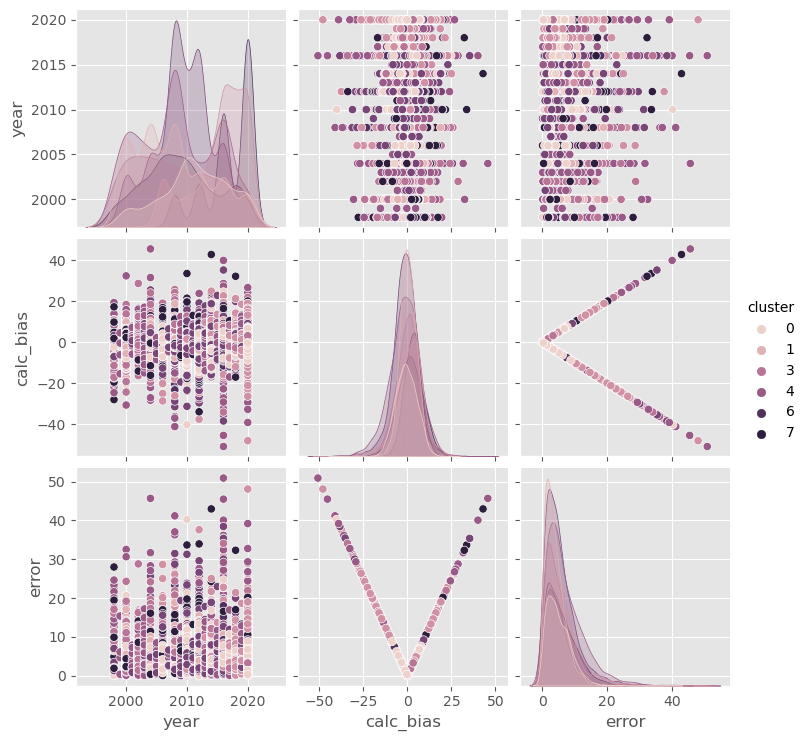

In [88]:
sns.pairplot(
    data = clustered[['year','calc_bias', 'error', 'cluster']],
    hue = 'cluster'
);

In [89]:
silhouette_score(kmeans_pipe.transform(X), clustered['cluster'])

0.4706421824331192

In [94]:
score = []

for k in [2, 19] + list(range(20, 31)):
    cl  = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        ('kmeans', KMeans(n_clusters = k, n_init = 10))
    ]
)
    cl.fit(X)

    sil = silhouette_score(cl.transform(X), cl['kmeans'].labels_)

    score.append((k, cl['kmeans'].inertia_, sil))

score_df = pd.DataFrame(score, columns = ['k', 'inertia', 'silhouette_score'])

score_df

,k,inertia,silhouette_score
0,2,13684.708867,0.625693
1,19,3598.069884,0.625305
2,20,3452.648333,0.632161
3,21,3304.874264,0.600289
4,22,3300.672718,0.587754
5,23,3160.889423,0.612202
6,24,3097.251722,0.607545
7,25,3033.113387,0.609257
8,26,2925.619546,0.609935
9,27,2865.483583,0.555270
